In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import BaseCrossValidator

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('merged_Interp_flat.csv')
df.head()

/var/folders/05/3kjdnq0n0rb3h2bnxdh0ys440000gn/T/ipykernel_8114/1275992891.py:1: DtypeWarning: Columns (3006,3007,3008,3009) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_Interp_flat.csv')


,cell_id,rated_capacity,cycle_index,capacity,soh,q_interp_0,q_interp_1,q_interp_2,q_interp_3,q_interp_4,...,e_interp_990,e_interp_991,e_interp_992,e_interp_993,e_interp_994,e_interp_995,e_interp_996,e_interp_997,e_interp_998,e_interp_999
0,B0005,2.0,1,1.856487,0.928244,1.873359,1.873359,1.873359,1.873359,1.873359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B0005,2.0,3,1.846327,0.923164,1.863255,1.863255,1.863255,1.863255,1.863255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B0005,2.0,5,1.835349,0.917675,1.841167,1.841167,1.841167,1.841167,1.841167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B0005,2.0,7,1.835263,0.917631,1.852058,1.852058,1.852058,1.852058,1.852058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B0005,2.0,9,1.834646,0.917323,1.851496,1.851496,1.851496,1.851496,1.851496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8852 entries, 0 to 8851
Columns: 4010 entries, cell_id to e_interp_999
dtypes: float64(4003), int64(1), object(6)
memory usage: 270.8+ MB


In [5]:
object_columns = df.select_dtypes(include='object').columns
print(object_columns)

Index(['cell_id', 'source', 'voltage_raw', 'charge_raw', 'temperature_raw',
       'time_raw'],
      dtype='object')


In [6]:
print(df[object_columns].head())

  cell_id source voltage_raw charge_raw temperature_raw time_raw
0   B0005   nasa         NaN        NaN             NaN      NaN
1   B0005   nasa         NaN        NaN             NaN      NaN
2   B0005   nasa         NaN        NaN             NaN      NaN
3   B0005   nasa         NaN        NaN             NaN      NaN
4   B0005   nasa         NaN        NaN             NaN      NaN


In [7]:
# Get column names at positions 3006 to 3009
cols = df.columns[[3006, 3007, 3008, 3009]]

# Show the column names
print(cols)

# Check the types of values in each column
for col in cols:
    print(f"Column {col}:")
    print(df[col].apply(type).value_counts())
    print()


Index(['voltage_raw', 'charge_raw', 'temperature_raw', 'time_raw'], dtype='object')
Column voltage_raw:
voltage_raw
<class 'float'>    8333
<class 'str'>       519
Name: count, dtype: int64

Column charge_raw:
charge_raw
<class 'float'>    8333
<class 'str'>       519
Name: count, dtype: int64

Column temperature_raw:
temperature_raw
<class 'float'>    8333
<class 'str'>       519
Name: count, dtype: int64

Column time_raw:
time_raw
<class 'float'>    8333
<class 'str'>       519
Name: count, dtype: int64



In [8]:
class BatteryWiseSplit(BaseCrossValidator):
    def __init__(self, n_splits=5, random_state=None, column_group='source'):
        self.n_splits = n_splits
        self.random_state = random_state
        self.column_group = column_group

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        df = X.copy()
        if 'cell_id' not in df.columns or self.column_group not in df.columns:
            raise ValueError("DataFrame must contain 'cell_id' and column group.")

        rng = np.random.RandomState(self.random_state)
        unique_batteries = df[["cell_id", self.column_group]].drop_duplicates()
        batteries_by_source = unique_batteries.groupby(self.column_group)["cell_id"].apply(list)
        folds = [[] for _ in range(self.n_splits)]

        for source, battery_list in batteries_by_source.items():
            rng.shuffle(battery_list)
            for i, cell_id in enumerate(battery_list):
                folds[i % self.n_splits].append(cell_id)

        for i in range(self.n_splits):
            val_batteries = set(folds[i])
            train_batteries = set(unique_batteries["cell_id"]) - val_batteries
            train_idx = df[df["cell_id"].isin(train_batteries)].index.values
            val_idx = df[df["cell_id"].isin(val_batteries)].index.values
            yield train_idx, val_idx


In [9]:
class BatteryTrainer:
    def __init__(self, df, target_cols, max_q=100, max_i=100):
        self.df = df.copy()
        self.target_cols = target_cols
        self.scaler = StandardScaler()

        # Ensure cell_id column is present
        if 'cell_id' not in self.df.columns:
            raise ValueError("DataFrame must contain 'cell_id' column.")

        # Select features based on name patterns
        q_cols = [c for c in df.columns if c.startswith('q_interp_')][:max_q]
        i_cols = [c for c in df.columns if c.startswith('i_interp_')][:max_i]
        self.feature_cols = q_cols + i_cols + ['cycle_index']

        self._prepare_data()

    def _prepare_data(self):
        splitter = BatteryWiseSplit(n_splits=5, random_state=42, column_group='source')
        self.df = self.df.reset_index(drop=True)
        train_idx, test_idx = next(splitter.split(self.df))

        self.train_idx = train_idx
        self.test_idx = test_idx

        train_df = self.df.iloc[train_idx]
        test_df = self.df.iloc[test_idx]

        self.X_train = self.scaler.fit_transform(train_df[self.feature_cols])
        self.X_val = self.scaler.transform(test_df[self.feature_cols])
        self.y_train = train_df[self.target_cols].values
        self.y_val = test_df[self.target_cols].values

    def train_xgboost(self, n_estimators=100, learning_rate=0.1, max_depth=6):
        self.xgb_model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )

        self.xgb_model.fit(self.X_train, self.y_train)

        train_preds = self.xgb_model.predict(self.X_train)
        val_preds = self.xgb_model.predict(self.X_val)

        self.train_mse = mean_squared_error(self.y_train, train_preds)
        self.train_mae = mean_absolute_error(self.y_train, train_preds)
        self.train_r2 = r2_score(self.y_train, train_preds)

        self.val_mse = mean_squared_error(self.y_val, val_preds)
        self.val_mae = mean_absolute_error(self.y_val, val_preds)
        self.val_r2 = r2_score(self.y_val, val_preds)

        print("XGBoost Training Results:")
        print(f"  Train MSE: {self.train_mse:.4f}")
        print(f"  Train MAE: {self.train_mae:.4f}")
        print(f"  Train R² : {self.train_r2:.4f}")
        print(f"  Val   MSE: {self.val_mse:.4f}")
        print(f"  Val   MAE: {self.val_mae:.4f}")
        print(f"  Val   R² : {self.val_r2:.4f}")

    def plot_metrics(self):
        metrics = {
            'MSE': (self.train_mse, self.val_mse),
            'MAE': (self.train_mae, self.val_mae),
            'R²': (self.train_r2, self.val_r2)
        }

        for name, (train_val, val_val) in metrics.items():
            plt.figure()
            plt.bar(['Train', 'Validation'], [train_val, val_val], color=['blue', 'green'], alpha=0.7)
            plt.title(f'{name} Comparison')
            plt.ylabel(name)
            plt.grid(True, axis='y', linestyle='--', alpha=0.5)
            plt.show()

    def plot_split_distribution(self):
        df_train = self.df.iloc[self.train_idx]
        df_test = self.df.iloc[self.test_idx]

        train_counts = df_train['cell_id'].value_counts().sort_index()
        test_counts = df_test['cell_id'].value_counts().sort_index()
        all_cell_ids = sorted(set(self.df['cell_id']))
        train_vals = [train_counts.get(cid, 0) for cid in all_cell_ids]
        test_vals = [test_counts.get(cid, 0) for cid in all_cell_ids]

        y = np.arange(len(all_cell_ids))
        height = 0.4

        plt.figure(figsize=(10, max(6, len(all_cell_ids) * 0.2)))
        plt.barh(y, train_vals, height=height, label='Train', alpha=0.7)
        plt.barh(y + height, test_vals, height=height, label='Test', alpha=0.7)
        plt.yticks(y + height / 2, all_cell_ids, fontsize=6)
        plt.ylabel('Battery ID')
        plt.xlabel('Cycle Count')
        plt.title('Train/Test Split by Battery ID')
        plt.legend()
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


XGBoost Training Results:
  Train MSE: 0.0000
  Train MAE: 0.0025
  Train R² : 0.9999
  Val   MSE: 0.0093
  Val   MAE: 0.0344
  Val   R² : 0.9690


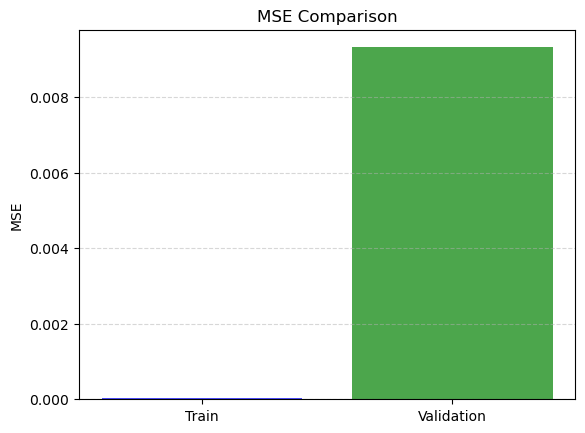

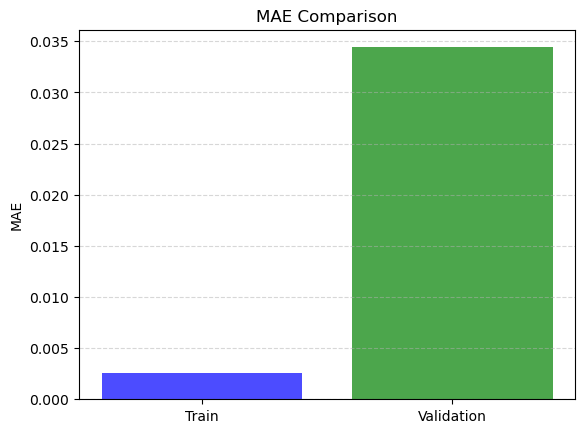

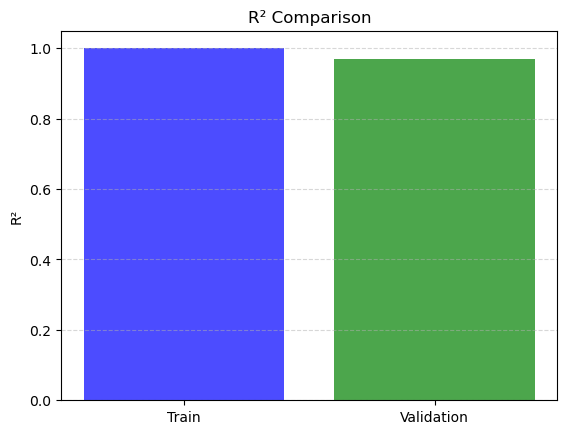

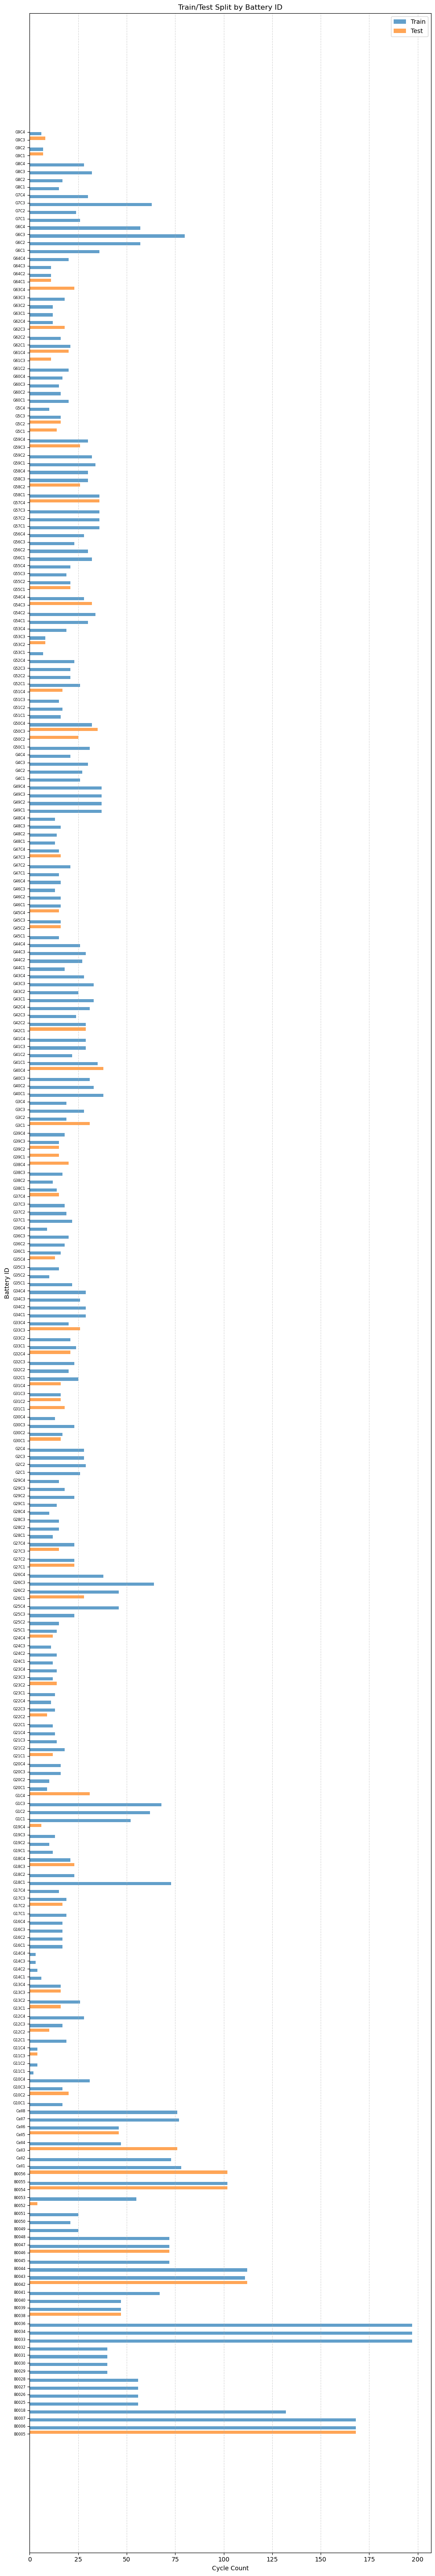

In [10]:
trainer = BatteryTrainer(df, target_cols=['capacity'])
trainer.train_xgboost()
trainer.plot_metrics()
trainer.plot_split_distribution()


___

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

class BatteryTrainer:
    def __init__(self, df, target_cols, max_q=100, max_i=100):
        self.df = df.copy().reset_index(drop=True)
        self.target_cols = target_cols
        self.scaler = StandardScaler()

        if 'cell_id' not in self.df.columns:
            raise ValueError("DataFrame must contain 'cell_id' column.")

        q_cols = [c for c in df.columns if c.startswith('q_interp_')][:max_q]
        i_cols = [c for c in df.columns if c.startswith('i_interp_')][:max_i]
        self.feature_cols = q_cols + i_cols + ['cycle_index']

    def cross_validate_xgboost(self, n_splits=5, n_estimators=100, learning_rate=0.1, max_depth=6):
        splitter = BatteryWiseSplit(n_splits=n_splits, random_state=42, column_group='source')

        self.fold_info = []  # store metadata per fold
        mse_scores, mae_scores, r2_scores = [], [], []

        for fold, (train_idx, val_idx) in enumerate(splitter.split(self.df), 1):
            print(f"\n=== Fold {fold} ===")
            train_df = self.df.iloc[train_idx]
            val_df = self.df.iloc[val_idx]

            X_train = self.scaler.fit_transform(train_df[self.feature_cols])
            X_val = self.scaler.transform(val_df[self.feature_cols])
            y_train = train_df[self.target_cols].values
            y_val = val_df[self.target_cols].values

            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            mse = mean_squared_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            mse_scores.append(mse)
            mae_scores.append(mae)
            r2_scores.append(r2)

            print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

            # Store fold metadata for diagnostics
            self.fold_info.append({
                'fold': fold,
                'val_cell_ids': val_df['cell_id'].unique(),
                'val_sources': val_df['source'].unique(),
                'val_idx': val_idx
            })

        self.mse_scores = mse_scores
        self.mae_scores = mae_scores
        self.r2_scores = r2_scores

        print("\n=== Average CV Performance ===")
        print(f"Avg MSE: {np.mean(mse_scores):.4f}")
        print(f"Avg MAE: {np.mean(mae_scores):.4f}")
        print(f"Avg R² : {np.mean(r2_scores):.4f}")

    def plot_metrics(self):
        if not hasattr(self, 'mse_scores'):
            raise AttributeError("Run cross_validate_xgboost() before plotting metrics.")

        metrics = {
            'MSE': self.mse_scores,
            'MAE': self.mae_scores,
            'R²': self.r2_scores
        }

        for name, values in metrics.items():
            plt.figure()
            plt.plot(range(1, len(values) + 1), values, marker='o')
            plt.title(f'{name} across CV folds')
            plt.xlabel('Fold')
            plt.ylabel(name)
            plt.grid(True)
            plt.xticks(range(1, len(values) + 1))
            plt.show()



=== Fold 1 ===
  MSE: 0.0093, MAE: 0.0344, R²: 0.9690

=== Fold 2 ===
  MSE: 0.0069, MAE: 0.0284, R²: 0.9822

=== Fold 3 ===
  MSE: 0.0045, MAE: 0.0184, R²: 0.9876

=== Fold 4 ===
  MSE: 0.0019, MAE: 0.0127, R²: 0.9939

=== Fold 5 ===
  MSE: 0.0040, MAE: 0.0180, R²: 0.9875

=== Average CV Performance ===
Avg MSE: 0.0053
Avg MAE: 0.0224
Avg R² : 0.9841


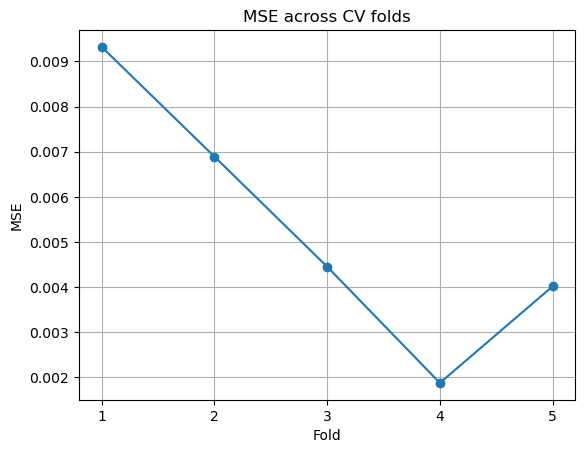

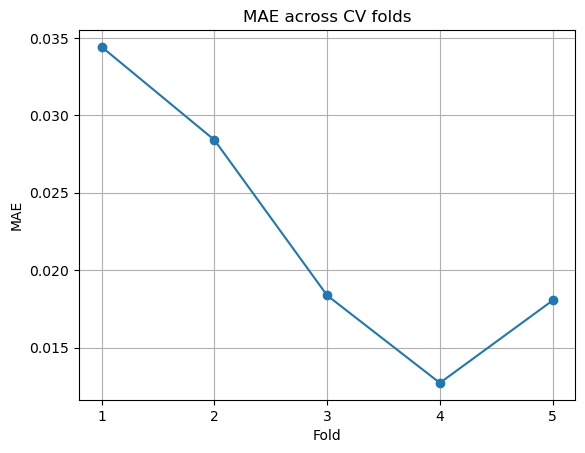

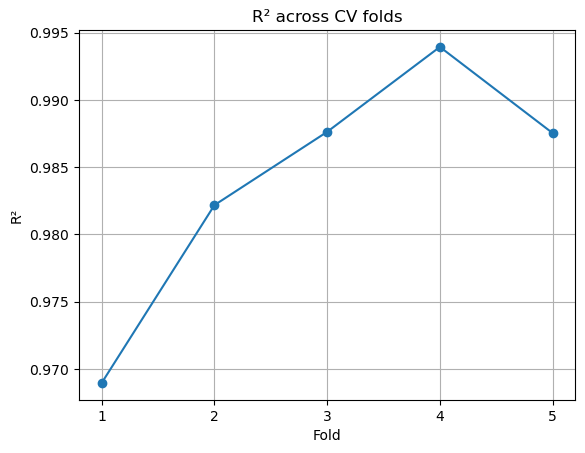

In [12]:
trainer_base = BatteryTrainer(df, target_cols=['capacity'])
trainer_base.cross_validate_xgboost()
trainer_base.plot_metrics()

In [13]:
fold5 = trainer_base.fold_info[4]  # fold index 5 = Fold 6 (since folds are 1-indexed in print, 0-indexed in code)
print("Fold 5 Batteries:", fold5['val_cell_ids'])
print("Fold 5 Sources:", fold5['val_sources'])

Fold 5 Batteries: ['B0026' 'B0031' 'B0034' 'B0043' 'B0044' 'B0045' 'Cell8' 'G7C1' 'G7C2'
 'G8C1' 'G10C1' 'G10C3' 'G11C1' 'G12C3' 'G14C1' 'G16C3' 'G17C3' 'G18C4'
 'G19C2' 'G19C3' 'G21C3' 'G22C1' 'G22C3' 'G24C2' 'G24C3' 'G25C3' 'G26C4'
 'G28C1' 'G28C4' 'G29C3' 'G30C2' 'G31C3' 'G32C3' 'G34C2' 'G34C4' 'G35C3'
 'G36C2' 'G37C3' 'G40C1' 'G44C3' 'G45C1' 'G46C2' 'G46C4' 'G47C4' 'G48C1'
 'G49C1' 'G49C2' 'G50C1' 'G52C1' 'G52C4' 'G53C1' 'G53C3' 'G55C3' 'G59C1'
 'G60C3' 'G62C1' 'G63C3']
Fold 5 Sources: ['nasa' 'oxford' 'isu']


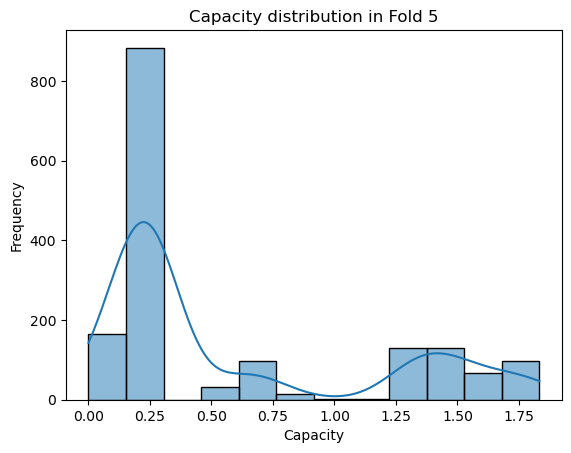

In [14]:
import seaborn as sns

fold_idx = 4  # Fold 5
val_idx = trainer_base.fold_info[fold_idx]['val_idx']

sns.histplot(trainer_base.df.iloc[val_idx]['capacity'], kde=True)
plt.title(f"Capacity distribution in Fold {fold_idx + 1}")
plt.xlabel("Capacity")
plt.ylabel("Frequency")
plt.show()


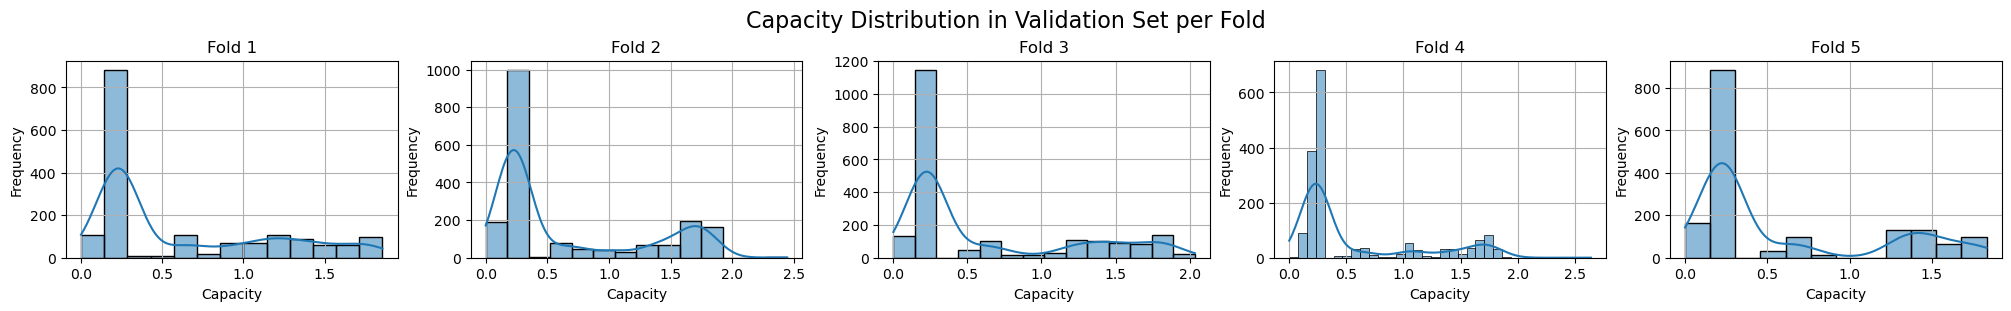

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Number of folds
n_folds = len(trainer_base.fold_info)

# Define grid size (auto-square)
n_cols = 5  # or adjust as needed
n_rows = math.ceil(n_folds / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, info in enumerate(trainer_base.fold_info):
    val_idx = info['val_idx']
    ax = axes[i]
    sns.histplot(trainer_base.df.iloc[val_idx]['capacity'], kde=True, ax=ax)
    ax.set_title(f"Fold {i+1}")
    ax.set_xlabel("Capacity")
    ax.set_ylabel("Frequency")
    ax.grid(True)

# Hide unused subplots (if n_folds doesn't fill the grid)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Capacity Distribution in Validation Set per Fold", fontsize=16)
plt.show()


In [16]:
import pandas as pd
from IPython.display import display

# Build a list of dictionaries, one for each fold
fold_summary = []

for i, fold in enumerate(trainer_base.fold_info):
    fold_summary.append({
        'Fold': i + 1,
        'Num Validation Batteries': len(fold['val_cell_ids']),
        'Validation Batteries': ', '.join(map(str, fold['val_cell_ids'])),
        'Validation Sources': ', '.join(map(str, fold['val_sources']))
    })

# Convert to DataFrame
fold_summary_df = pd.DataFrame(fold_summary)

# Display full content without truncation
with pd.option_context('display.max_colwidth', None):
    display(fold_summary_df)


,Fold,Num Validation Batteries,Validation Batteries,Validation Sources
0,1,60,"B0005, B0038, B0042, B0046, B0052, B0054, B0056, Cell3, Cell5, G1C4, G3C1, G5C1, G5C2, G9C1, G9C3, G10C2, G11C3, G12C2, G13C1, G13C3, G17C2, G18C3, G19C4, G21C1, G22C2, G23C2, G24C4, G26C1, G27C1, G27C3, G30C1, G31C1, G31C2, G31C4, G32C4, G33C3, G35C4, G37C4, G38C4, G39C1, G39C2, G40C4, G42C1, G45C2, G45C4, G47C3, G50C2, G50C3, G51C4, G53C2, G54C3, G55C1, G57C4, G58C2, G59C3, G61C3, G61C4, G62C3, G63C4, G64C1","nasa, oxford, isu"
1,2,59,"B0027, B0028, B0033, B0036, B0049, B0051, B0053, Cell4, Cell6, G1C1, G2C2, G2C3, G4C2, G5C3, G5C4, G7C3, G7C4, G8C4, G9C2, G10C4, G11C2, G13C4, G14C4, G18C1, G18C2, G20C4, G22C4, G23C3, G23C4, G24C1, G26C2, G28C2, G28C3, G29C1, G32C2, G34C1, G34C3, G37C2, G38C3, G40C2, G41C2, G41C3, G42C2, G43C3, G44C1, G46C1, G46C3, G48C3, G50C4, G51C3, G53C4, G54C1, G54C4, G56C2, G56C3, G58C3, G59C4, G60C2, G63C1","nasa, oxford, isu"
2,3,59,"B0006, B0007, B0025, B0040, B0041, B0047, B0048, Cell1, Cell2, G1C3, G2C4, G3C3, G4C1, G4C3, G4C4, G6C2, G6C3, G6C4, G8C2, G11C4, G12C1, G13C2, G14C2, G16C1, G16C4, G17C4, G20C1, G20C2, G21C4, G25C4, G29C2, G29C4, G30C3, G30C4, G33C1, G36C1, G37C1, G39C4, G40C3, G41C4, G43C1, G43C4, G45C3, G48C2, G48C4, G52C3, G55C4, G56C4, G57C1, G57C3, G58C1, G58C4, G60C1, G61C2, G62C2, G62C4, G64C2, G64C3, G64C4","nasa, oxford, isu"
3,4,58,"B0018, B0029, B0030, B0032, B0039, B0050, B0055, Cell7, G1C2, G2C1, G3C2, G3C4, G6C1, G8C3, G9C4, G12C4, G14C3, G16C2, G17C1, G19C1, G20C3, G21C2, G23C1, G25C1, G25C2, G26C3, G27C2, G27C4, G32C1, G33C2, G33C4, G35C1, G35C2, G36C3, G36C4, G38C1, G38C2, G39C3, G41C1, G42C3, G42C4, G43C2, G44C2, G44C4, G47C1, G47C2, G49C3, G49C4, G51C1, G51C2, G52C2, G54C2, G55C2, G56C1, G57C2, G59C2, G60C4, G63C2","nasa, oxford, isu"
4,5,57,"B0026, B0031, B0034, B0043, B0044, B0045, Cell8, G7C1, G7C2, G8C1, G10C1, G10C3, G11C1, G12C3, G14C1, G16C3, G17C3, G18C4, G19C2, G19C3, G21C3, G22C1, G22C3, G24C2, G24C3, G25C3, G26C4, G28C1, G28C4, G29C3, G30C2, G31C3, G32C3, G34C2, G34C4, G35C3, G36C2, G37C3, G40C1, G44C3, G45C1, G46C2, G46C4, G47C4, G48C1, G49C1, G49C2, G50C1, G52C1, G52C4, G53C1, G53C3, G55C3, G59C1, G60C3, G62C1, G63C3","nasa, oxford, isu"


## Hyper-parameter Tuning - Using MAE

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

class BatteryTrainer:
    def __init__(self, df, target_cols, max_q=100, max_i=100):
        self.df = df.copy().reset_index(drop=True)
        self.target_cols = target_cols
        self.scaler = StandardScaler()

        if 'cell_id' not in self.df.columns:
            raise ValueError("DataFrame must contain 'cell_id' column.")

        q_cols = [c for c in df.columns if c.startswith('q_interp_')][:max_q]
        i_cols = [c for c in df.columns if c.startswith('i_interp_')][:max_i]
        self.feature_cols = q_cols + i_cols + ['cycle_index']

    def cross_validate_xgboost(self, n_splits=5, n_estimators=100, learning_rate=0.1, max_depth=6, verbose=True):
        splitter = BatteryWiseSplit(n_splits=n_splits, random_state=42, column_group='source')

        self.fold_info = []  # store metadata per fold
        mse_scores, mae_scores, r2_scores = [], [], []

        for fold, (train_idx, val_idx) in enumerate(splitter.split(self.df), 1):
            if verbose:
                print(f"\n=== Fold {fold} ===")
            train_df = self.df.iloc[train_idx]
            val_df = self.df.iloc[val_idx]

            X_train = self.scaler.fit_transform(train_df[self.feature_cols])
            X_val = self.scaler.transform(val_df[self.feature_cols])
            y_train = train_df[self.target_cols].values
            y_val = val_df[self.target_cols].values

            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            mse = mean_squared_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            mse_scores.append(mse)
            mae_scores.append(mae)
            r2_scores.append(r2)

            if verbose:
                print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

            self.fold_info.append({
                'fold': fold,
                'val_cell_ids': val_df['cell_id'].unique(),
                'val_sources': val_df['source'].unique(),
                'val_idx': val_idx
            })

        self.mse_scores = mse_scores
        self.mae_scores = mae_scores
        self.r2_scores = r2_scores

        if verbose:
            print("\n=== Average CV Performance ===")
            print(f"Avg MSE: {np.mean(mse_scores):.4f}")
            print(f"Avg MAE: {np.mean(mae_scores):.4f}")
            print(f"Avg R² : {np.mean(r2_scores):.4f}")

    def plot_metrics(self):
        if not hasattr(self, 'mse_scores'):
            raise AttributeError("Run cross_validate_xgboost() before plotting metrics.")

        metrics = {
            'MSE': self.mse_scores,
            'MAE': self.mae_scores,
            'R²': self.r2_scores
        }

        for name, values in metrics.items():
            plt.figure()
            plt.plot(range(1, len(values) + 1), values, marker='o')
            plt.title(f'{name} across CV folds')
            plt.xlabel('Fold')
            plt.ylabel(name)
            plt.grid(True)
            plt.xticks(range(1, len(values) + 1))
            plt.show()

    def tune_xgboost(self, param_grid):
        best_config = None
        best_score = float('inf')  # will now use MAE for selection
        all_results = []

        print("\n=== Hyperparameter Tuning (Optimizing for MAE) ===")

        # Expand param grid using itertools.product
        keys, values = zip(*param_grid.items())
        combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        self.tuning_logs = []  # Store per-combination training results

        for params in combinations:
            print(f"Trying: {params}")
            self.cross_validate_xgboost(
                n_splits=5,
                n_estimators=params.get("n_estimators", 100),
                learning_rate=params.get("learning_rate", 0.1),
                max_depth=params.get("max_depth", 6),
                verbose=False
            )

            mean_mse = np.mean(self.mse_scores)
            mean_mae = np.mean(self.mae_scores)  # use this for selection
            mean_r2 = np.mean(self.r2_scores)

            all_results.append((params, mean_mae))
            self.tuning_logs.append({
                "params": params,
                "avg_mse": mean_mse,
                "avg_mae": mean_mae,
                "avg_r2": mean_r2
            })

            if mean_mae < best_score:
                best_score = mean_mae
                best_config = params

        print("\n=== Tuning Results ===")
        for result in sorted(self.tuning_logs, key=lambda x: x['avg_mae']):
            print(f"{result['params']} → Avg MAE: {result['avg_mae']:.4f}, MSE: {result['avg_mse']:.4f}, R²: {result['avg_r2']:.4f}")

        print(f"\n✅ Best Params (by MAE): {best_config} with Avg MAE: {best_score:.4f}")
        self.best_params = best_config

In [18]:
param_grid = {
    "n_estimators": [100, 300],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 6],
}

In [19]:
trainer_tuned_mae = BatteryTrainer(df, target_cols=['capacity'])
trainer_tuned_mae.tune_xgboost(param_grid)


=== Hyperparameter Tuning (Optimizing for MAE) ===
Trying: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3}
Trying: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 6}
Trying: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
Trying: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6}
Trying: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 3}
Trying: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 6}
Trying: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 3}
Trying: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6}

=== Tuning Results ===
{'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6} → Avg MAE: 0.0221, MSE: 0.0053, R²: 0.9841
{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6} → Avg MAE: 0.0224, MSE: 0.0053, R²: 0.9841
{'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 3} → Avg MAE: 0.0230, MSE: 0.0049, R²: 0.9852
{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3} → Avg M


=== Fold 1 ===
  MSE: 0.0091, MAE: 0.0336, R²: 0.9697

=== Fold 2 ===
  MSE: 0.0069, MAE: 0.0283, R²: 0.9822

=== Fold 3 ===
  MSE: 0.0046, MAE: 0.0181, R²: 0.9873

=== Fold 4 ===
  MSE: 0.0019, MAE: 0.0125, R²: 0.9940

=== Fold 5 ===
  MSE: 0.0040, MAE: 0.0181, R²: 0.9875

=== Average CV Performance ===
Avg MSE: 0.0053
Avg MAE: 0.0221
Avg R² : 0.9841


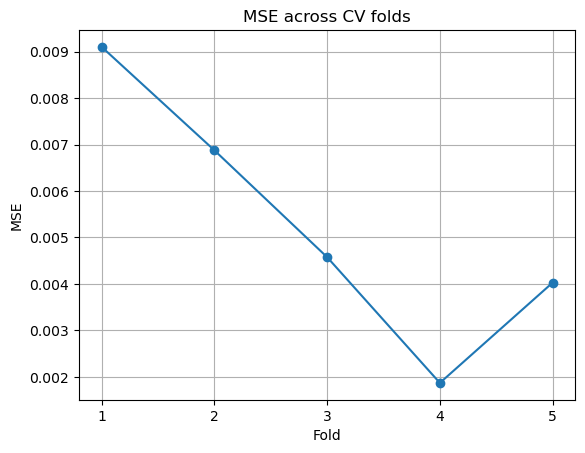

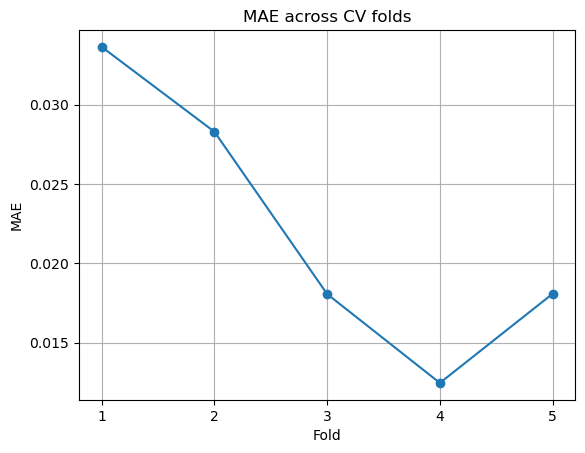

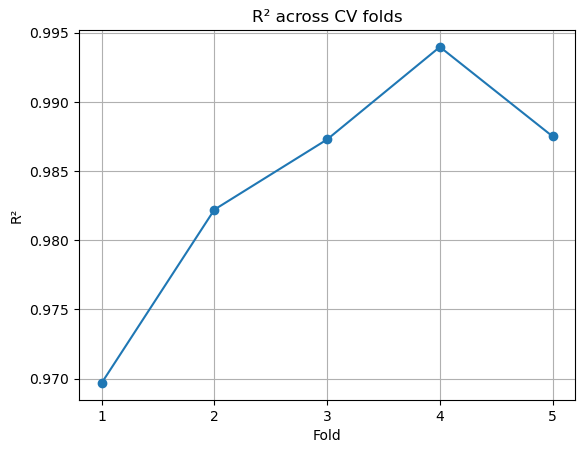

In [20]:
# Retrain with best config
trainer_tuned_mae.cross_validate_xgboost(
    n_splits=5,
    verbose=True,
    **trainer_tuned_mae.best_params
)

trainer_tuned_mae.plot_metrics()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_comparison_boxplots(base_scores, tuned_scores):
    """
    base_scores & tuned_scores should be dicts like:
    {
        'MSE': [...],
        'MAE': [...],
        'R²': [...]
    }
    """

    # Prepare DataFrame
    data = []
    for metric in ['MSE', 'MAE', 'R²']:
        for score in base_scores[metric]:
            data.append({'Metric': metric, 'Score': score, 'Model': 'Base'})
        for score in tuned_scores[metric]:
            data.append({'Metric': metric, 'Score': score, 'Model': 'Tuned'})
    df = pd.DataFrame(data)

    # Plot grid
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

    for i, metric in enumerate(['MSE', 'MAE', 'R²']):
        ax = axes[i]
        sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
        sns.stripplot(data=df[df['Metric'] == metric], x='Model', y='Score', color='black', alpha=0.5, jitter=True, ax=ax)
        ax.set_title(metric)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    fig.suptitle("Cross-Validation Performance: Base vs Tuned", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


/var/folders/05/3kjdnq0n0rb3h2bnxdh0ys440000gn/T/ipykernel_8114/610721770.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/var/folders/05/3kjdnq0n0rb3h2bnxdh0ys440000gn/T/ipykernel_8114/610721770.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/var/folders/05/3kjdnq0n0rb3h2bnxdh0ys440000gn/T/ipykernel_8114/610721770.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df

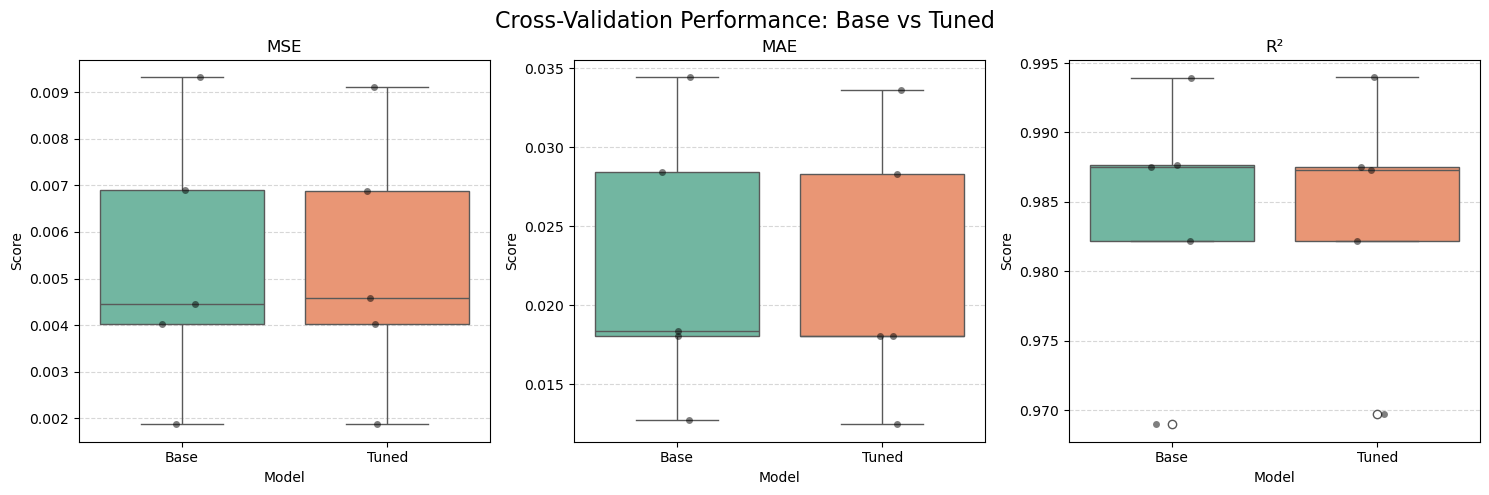

In [22]:
# Save scores from the base model
base_scores = {
    'MSE': trainer_base.mse_scores,
    'MAE': trainer_base.mae_scores,
    'R²': trainer_base.r2_scores
}

# Save scores from the tuned model
tuned_scores = {
    'MSE': trainer_tuned_mae.mse_scores,
    'MAE': trainer_tuned_mae.mae_scores,
    'R²': trainer_tuned_mae.r2_scores
}

# Plot comparison
plot_comparison_boxplots(base_scores, tuned_scores)


## Hyper-parameter Tuning - Using MSE

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

class BatteryTrainer:
    def __init__(self, df, target_cols, max_q=100, max_i=100):
        self.df = df.copy().reset_index(drop=True)
        self.target_cols = target_cols
        self.scaler = StandardScaler()

        if 'cell_id' not in self.df.columns:
            raise ValueError("DataFrame must contain 'cell_id' column.")

        q_cols = [c for c in df.columns if c.startswith('q_interp_')][:max_q]
        i_cols = [c for c in df.columns if c.startswith('i_interp_')][:max_i]
        self.feature_cols = q_cols + i_cols + ['cycle_index']

    def cross_validate_xgboost(self, n_splits=5, n_estimators=100, learning_rate=0.1, max_depth=6, verbose=True):
        splitter = BatteryWiseSplit(n_splits=n_splits, random_state=42, column_group='source')

        self.fold_info = []  # store metadata per fold
        mse_scores, mae_scores, r2_scores = [], [], []

        for fold, (train_idx, val_idx) in enumerate(splitter.split(self.df), 1):
            if verbose:
                print(f"\n=== Fold {fold} ===")
            train_df = self.df.iloc[train_idx]
            val_df = self.df.iloc[val_idx]

            X_train = self.scaler.fit_transform(train_df[self.feature_cols])
            X_val = self.scaler.transform(val_df[self.feature_cols])
            y_train = train_df[self.target_cols].values
            y_val = val_df[self.target_cols].values

            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            mse = mean_squared_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            mse_scores.append(mse)
            mae_scores.append(mae)
            r2_scores.append(r2)

            if verbose:
                print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

            self.fold_info.append({
                'fold': fold,
                'val_cell_ids': val_df['cell_id'].unique(),
                'val_sources': val_df['source'].unique(),
                'val_idx': val_idx
            })

        self.mse_scores = mse_scores
        self.mae_scores = mae_scores
        self.r2_scores = r2_scores

        if verbose:
            print("\n=== Average CV Performance ===")
            print(f"Avg MSE: {np.mean(mse_scores):.4f}")
            print(f"Avg MAE: {np.mean(mae_scores):.4f}")
            print(f"Avg R² : {np.mean(r2_scores):.4f}")

    def plot_metrics(self):
        if not hasattr(self, 'mse_scores'):
            raise AttributeError("Run cross_validate_xgboost() before plotting metrics.")

        metrics = {
            'MSE': self.mse_scores,
            'MAE': self.mae_scores,
            'R²': self.r2_scores
        }

        for name, values in metrics.items():
            plt.figure()
            plt.plot(range(1, len(values) + 1), values, marker='o')
            plt.title(f'{name} across CV folds')
            plt.xlabel('Fold')
            plt.ylabel(name)
            plt.grid(True)
            plt.xticks(range(1, len(values) + 1))
            plt.show()

    def tune_xgboost(self, param_grid):
        best_config = None
        best_score = float('inf')
        all_results = []

        print("\n=== Hyperparameter Tuning ===")

        # Expand param grid using itertools.product
        keys, values = zip(*param_grid.items())
        combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        self.tuning_logs = []  # Store per-combination training results

        for params in combinations:
            print(f"Trying: {params}")
            self.cross_validate_xgboost(
                n_splits=5,
                n_estimators=params.get("n_estimators", 100),
                learning_rate=params.get("learning_rate", 0.1),
                max_depth=params.get("max_depth", 6),
                verbose=False
            )

            mean_mse = np.mean(self.mse_scores)
            mean_mae = np.mean(self.mae_scores)
            mean_r2 = np.mean(self.r2_scores)

            all_results.append((params, mean_mse))
            self.tuning_logs.append({
                "params": params,
                "avg_mse": mean_mse,
                "avg_mae": mean_mae,
                "avg_r2": mean_r2
            })

            if mean_mse < best_score:
                best_score = mean_mse
                best_config = params

        print("\n=== Tuning Results ===")
        for result in sorted(self.tuning_logs, key=lambda x: x['avg_mse']):
            print(f"{result['params']} → Avg MSE: {result['avg_mse']:.4f}, MAE: {result['avg_mae']:.4f}, R²: {result['avg_r2']:.4f}")

        print(f"\n✅ Best Params: {best_config} with Avg MSE: {best_score:.4f}")
        self.best_params = best_config


In [24]:
trainer_tuned_mse = BatteryTrainer(df, target_cols=['capacity'])
trainer_tuned_mse.tune_xgboost(param_grid)


=== Hyperparameter Tuning ===
Trying: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3}
Trying: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 6}
Trying: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
Trying: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6}
Trying: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 3}
Trying: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 6}
Trying: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 3}
Trying: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6}

=== Tuning Results ===
{'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 3} → Avg MSE: 0.0049, MAE: 0.0230, R²: 0.9852
{'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6} → Avg MSE: 0.0053, MAE: 0.0221, R²: 0.9841
{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3} → Avg MSE: 0.0053, MAE: 0.0240, R²: 0.9840
{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6} → Avg MSE: 0.0053, MAE: 0.02

In [25]:
print(trainer_tuned_mse.best_params)

{'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 3}



=== Fold 1 ===
  MSE: 0.0097, MAE: 0.0370, R²: 0.9679

=== Fold 2 ===
  MSE: 0.0063, MAE: 0.0294, R²: 0.9837

=== Fold 3 ===
  MSE: 0.0032, MAE: 0.0171, R²: 0.9910

=== Fold 4 ===
  MSE: 0.0011, MAE: 0.0109, R²: 0.9963

=== Fold 5 ===
  MSE: 0.0041, MAE: 0.0209, R²: 0.9874

=== Average CV Performance ===
Avg MSE: 0.0049
Avg MAE: 0.0230
Avg R² : 0.9852


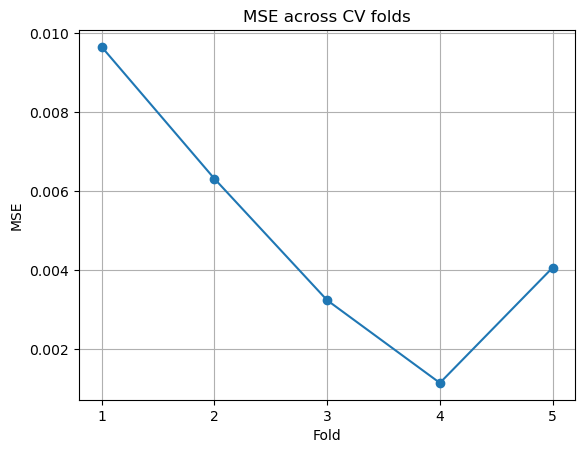

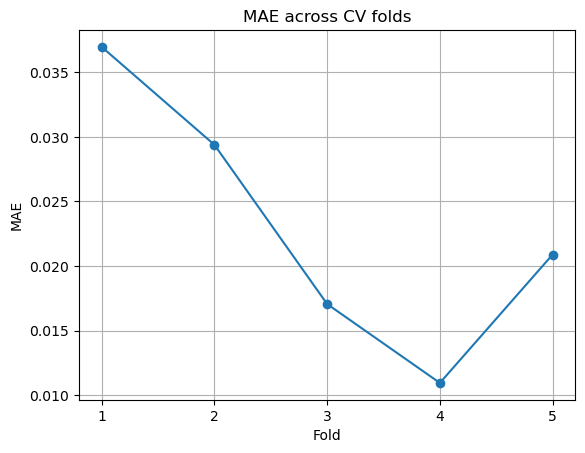

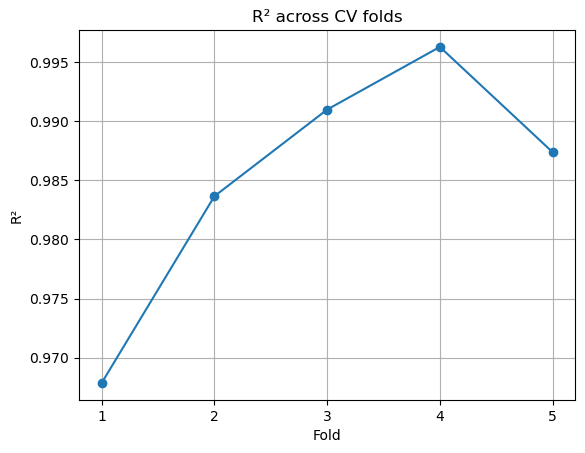

In [28]:
# Retrain with best config
trainer_tuned_mse.cross_validate_xgboost(
    n_splits=5,
    verbose=True,
    **trainer_tuned_mse.best_params
)

trainer_tuned_mse.plot_metrics()


/var/folders/05/3kjdnq0n0rb3h2bnxdh0ys440000gn/T/ipykernel_8114/610721770.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/var/folders/05/3kjdnq0n0rb3h2bnxdh0ys440000gn/T/ipykernel_8114/610721770.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/var/folders/05/3kjdnq0n0rb3h2bnxdh0ys440000gn/T/ipykernel_8114/610721770.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df

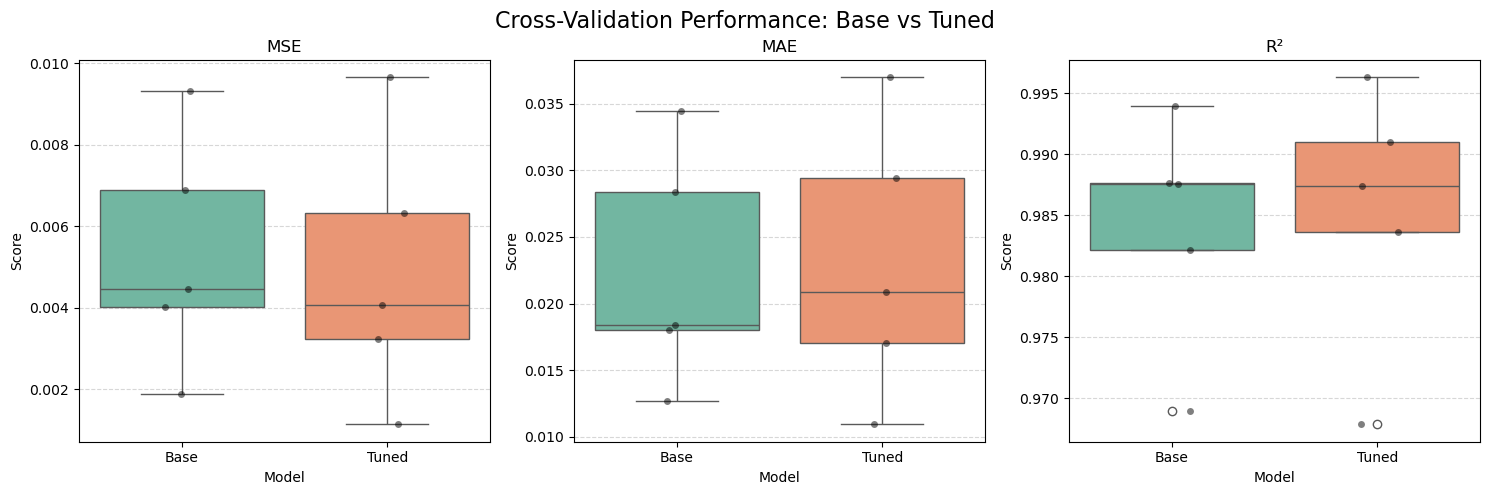

In [27]:
# Save scores from the base model
base_scores = {
    'MSE': trainer_base.mse_scores,
    'MAE': trainer_base.mae_scores,
    'R²': trainer_base.r2_scores
}

# Save scores from the tuned model
tuned_scores = {
    'MSE': trainer_tuned_mse.mse_scores,
    'MAE': trainer_tuned_mse.mae_scores,
    'R²': trainer_tuned_mse.r2_scores
}

# Plot comparison
plot_comparison_boxplots(base_scores, tuned_scores)
